<a href="https://colab.research.google.com/github/morbosohex/Workflow/blob/master/Simple_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/dl-tensorflow/autoencoder')

# 简单的自编码器

我们首先构建一个简单的自动编码器来压缩MNIST数据集。使用自动编码器，我们通过编码器传递输入数据，该编码器对输入进行压缩表示。然后，该表示通过解码器以重建输入数据。通常，编码器和解码器将使用神经网络构建，然后在示例数据上进行训练。

![Autoencoder](assets/autoencoder_1.png)

我们将为编码器和解码器构建一个简单的网络架构。让我们开始导入我们的库并获取数据集。

In [0]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

W0823 02:41:50.241367 140189599811456 deprecation.py:323] From <ipython-input-2-8c515496db61>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0823 02:41:50.243097 140189599811456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0823 02:41:50.247477 140189599811456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz


W0823 02:41:50.594754 140189599811456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz


W0823 02:41:50.890381 140189599811456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Below I'm plotting an example image from the MNIST dataset. These are 28x28 grayscale images of handwritten digits.

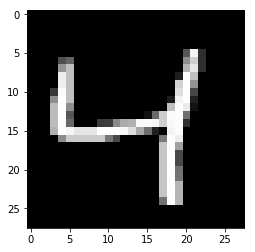

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

我们将通过将它们展平为长度为784的向量来训练带有这些图像的自动编码器。来自此数据集的图像已经标准化，使得值介于0和1之间。让我们首先构建基本上最简单的自动编码器，其中包含**单个ReLU隐藏层**。该层将用作压缩表示。然后，编码器是输入层和隐藏层。解码器是隐藏层和输出层。由于图像在0和1之间归一化，我们需要在输出层**上使用sigmoid激活**来获得与输入匹配的值。

![image.png](https://upload-images.jianshu.io/upload_images/12735209-c9c34f5997993ae1.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)




**练习：**在下面的单元格中构建自动编码器的图形。输入图像将被展平为784个长度向量。目标与输入相同。并且应该有一个具有ReLU激活的隐藏层和一个具有S形激活的输出层。随意使用TensorFlow的更高级API，`tf.layers`。例如，你可以使用[`tf.layers.dense（inputs，units，activation = tf.nn.relu）`]（https://www.tensorflow.org/api_docs/python/tf/layers/dense）来使用ReLU激活创建完全连接的图层。应该用交叉熵损失计算损失，这个`tf.nn.sigmoid_cross_entropy_with_logits`有一个方便的TensorFlow函数（[文档]（https://www.tensorflow.org/api_docs/python/tf/nn/） sigmoid_cross_entropy_with_logits））。你应该注意`tf.nn.sigmoid_cross_entropy_with_logits`获取logits，但是要获得重建的图像，你需要通过sigmoid函数传递logits。

In [5]:
# Size of the encoding layer (the hidden layer)
encoding_dim = 32 # feel free to change this value

image_size = mnist.train.images.shape[1]

# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, [None, image_size], name="inputs")
targets_ = tf.placeholder(tf.float32, [None, image_size], name="targets")

# Output of hidden layer, single fully connected layer here with ReLU activation
encoded = tf.layers.dense(inputs_, encoding_dim, activation=tf.nn.relu)

# Output layer logits, fully connected layer with no activation
logits = tf.layers.dense(encoded, image_size, activation=None)
# Sigmoid output from logits
decoded = tf.nn.sigmoid(logits, name='output')

# Sigmoid cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets_)
# Mean of the loss
cost = tf.reduce_mean(loss)

# Adam optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

W0823 05:09:09.437795 140189599811456 deprecation.py:323] From <ipython-input-5-60fe66d45877>:10: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0823 05:09:09.448254 140189599811456 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0823 05:09:09.919813 140189599811456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast

## Training

In [0]:
# Create the session
sess = tf.Session()

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss. 

调用`mnist.train.next_batch（batch_size）`将返回`（images，labels）`的元组。我们不关心这里的标签，我们只需要图像。否则，这是TensorFlow非常直接的培训。我们用`sess.run（tf.global_variables_initializer（））`初始化变量。然后，运行优化器并使用`batch_cost，_ = sess.run（[cost，opt]，feed_dict = feed）`获得损失。

In [7]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        feed = {inputs_: batch[0], targets_: batch[0]}
        batch_cost, _ = sess.run([cost, opt], feed_dict=feed)

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6952
Epoch: 1/20... Training loss: 0.6947
Epoch: 1/20... Training loss: 0.6947
Epoch: 1/20... Training loss: 0.6942
Epoch: 1/20... Training loss: 0.6939
Epoch: 1/20... Training loss: 0.6936
Epoch: 1/20... Training loss: 0.6935
Epoch: 1/20... Training loss: 0.6932
Epoch: 1/20... Training loss: 0.6928
Epoch: 1/20... Training loss: 0.6925
Epoch: 1/20... Training loss: 0.6923
Epoch: 1/20... Training loss: 0.6920
Epoch: 1/20... Training loss: 0.6918
Epoch: 1/20... Training loss: 0.6916
Epoch: 1/20... Training loss: 0.6914
Epoch: 1/20... Training loss: 0.6911
Epoch: 1/20... Training loss: 0.6906
Epoch: 1/20... Training loss: 0.6904
Epoch: 1/20... Training loss: 0.6903
Epoch: 1/20... Training loss: 0.6898
Epoch: 1/20... Training loss: 0.6895
Epoch: 1/20... Training loss: 0.6891
Epoch: 1/20... Training loss: 0.6889
Epoch: 1/20... Training loss: 0.6885
Epoch: 1/20... Training loss: 0.6882
Epoch: 1/20... Training loss: 0.6880
Epoch: 1/20... Training loss: 0.6876
E

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

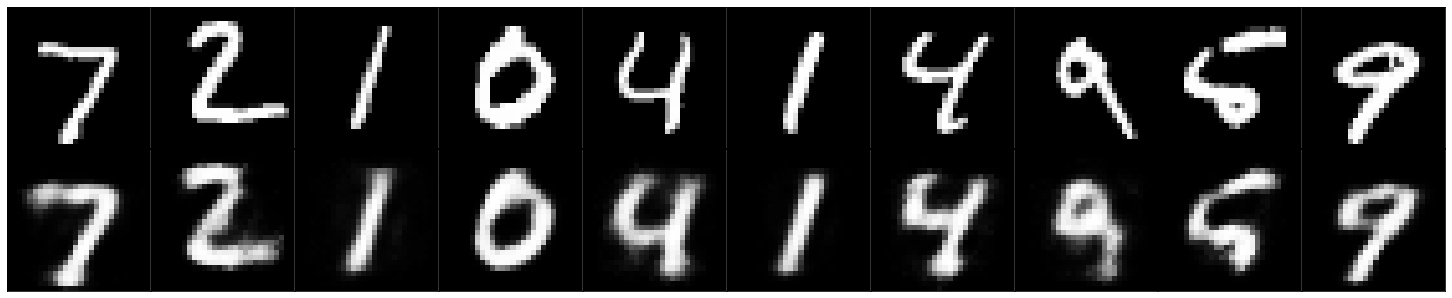

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={inputs_: in_imgs})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [0]:
sess.close()

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.

In practice, autoencoders aren't actually better at compression compared to typical methods like JPEGs and MP3s. But, they are being used for noise reduction, which you'll also build.